## Analyzing ICESat-2 ATL10 test data
    
Description: This notebook shows hwo to read in ICESat-2 test freeboard data (ATL10)

Input requirements: ICESat-2 test data files

In [69]:
# Load Python modules
%matplotlib inline
import matplotlib
from mpl_toolkits.basemap import Basemap, shiftgrid
from pylab import *
import numpy.ma as ma
import seaborn as sns
from glob import glob
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd
import h5py
#import os
#import netCDF4 as nc4

#import sys
#sys.path.append('../')
#import common_functions as cF


sns.set_style("whitegrid")
# Set folder links
figPath='../../Figures/IS1/'
dataOutPath='../../DataOutput/IS1/'
rawDataPath='/home/aapetty/Data/'

dataPath='/home/aapetty/Data/ICESat-2/TestData/ATL10/'
    

In [70]:
fileStr='ATL10_20151027T051043_00890302_943_01.h5'
fileT=dataPath+fileStr

def getATL10(fileT):
    f1 = h5py.File(fileT, 'r')
    freeboard=f1['freeboard_swath_segment']['fbswath_fb_height'][:]
    lons=f1['freeboard_swath_segment']['longitude'][:]
    lats=f1['freeboard_swath_segment']['latitude'][:]

    dF = pd.DataFrame({'freeboard':freeboard, 'lons':lons, 'lats':lats})
    dF = dF[(dF['freeboard']>0)]
    dF = dF[(dF['freeboard']<10)]

    # Reset row indexing
    dF=dF.reset_index(drop=True)
    dF['year'] = fileStr[6:10]
    dF['month'] = fileStr[10:12]
    dF['day'] = fileStr[12:14]
    
    return dF

def getATL10FreeboardShotData(fileT, mapProj, beamStr='gt1r'):
    """
    Load ATL10 freeboard shot data from a given beam
    # Store in a Pandas dataframe

    Args:
        freeboardFileT (file): file path of ICESat freeboard data
        mapProj (basemap instance): basemap map projection
        beamStr (str): ground track (gt1, gt2, gt3) then the weak (l) and strong (r) beam
            i.e. gt1r is the strong beam from ground track 1

    
    Returns:
        dF (var): Dataframe containing freeboard, year, month, day, lon, lat, x, y

    I think the dates are indexed starting from 1 - i.e. month of 1 = January 
        
    """

    # stopped with this as beams are not co-located..
    #if isinstance(a, (list,)):
    #    print('grabbing multiple beams')
    #else:
    #   print('grabbing single beam:', beamStr)



    print('ATL10 file:', fileT)
    
    f1 = h5py.File(fileT, 'r')
    try:
        freeboard=f1[beamStr]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]
    except:
        return 'No good shot data'

    freeboard_confidence=f1[beamStr]['freeboard_beam_segment']['beam_freeboard']['beam_fb_confidence'][:]
    freeboard_quality=f1[beamStr]['freeboard_beam_segment']['beam_freeboard']['beam_fb_quality_flag'][:]
    
    lons=f1[beamStr]['freeboard_beam_segment']['beam_freeboard']['longitude'][:]
    lats=f1[beamStr]['freeboard_beam_segment']['beam_freeboard']['latitude'][:]
    deltaTime=f1[beamStr]['freeboard_beam_segment']['beam_freeboard']['delta_time'][:]

    dF = pd.DataFrame({'freeboard':freeboard, 'lon':lons, 'lat':lats, 'delta_time':deltaTime})

    dF = dF[(dF['freeboard']>0)]
    dF = dF[(dF['freeboard']<10)]

    # Decide here if we want to also filter based on the confidence and/or quality flag

    # Reset row indexing
    dF=dF.reset_index(drop=True)

    print(fileT)
    fileStr=fileT.split("/ATL10_")[-1]
    print(fileStr)
    dF['year'] = int(fileStr[0:4])
    dF['month'] = int(fileStr[4:6])
    dF['day'] = int(fileStr[6:8])

    print('Year:', fileStr[0:4], 'Month:', fileStr[4:6], 'Day:', fileStr[6:8])
    

    xpts, ypts=mapProj(dF['lon'].values, dF['lat'].values)

    dF['xpts'] = pd.Series(xpts, index=dF.index)
    dF['ypts'] = pd.Series(ypts, index=dF.index)

    dF['shot'] = beamStr
    

    return dF


In [71]:
ATL10file = getATL10(fileT)
ATL10file.head(4)

,freeboard,lats,lons,year,month,day
0,0.170991,-68.728474,-176.304110,2015,10,27
1,0.077395,-68.817714,-176.319886,2015,10,27
2,0.125154,-68.894080,-176.341362,2015,10,27
3,0.067497,-68.987788,-176.397059,2015,10,27


In [72]:
# Create map of the Southern Ocean, project lon/lats to this map, add to dataframe.
#m=Basemap(projection='pstere', lat_0=74, lon_0=-90,llcrnrlon=-150, llcrnrlat=58,urcrnrlon=10, urcrnrlat=72)
m = Basemap(projection='spstere',boundinglat=-60,lon_0=-180, resolution='l' , round=True)

xpts, ypts=m(ATL10file['lons'].values, ATL10file['lats'].values)
ATL10file['xpts'] = pd.Series(xpts, index=ATL10file.index)
ATL10file['ypts'] = pd.Series(ypts, index=ATL10file.index)
alongTrackDist=sqrt((xpts-xpts[0])**2+(ypts-ypts[0])**2)/1000.
ATL10file['alongTrackDist'] = pd.Series(alongTrackDist, index=ATL10file.index)

ATL10file.tail(5)

,freeboard,lats,lons,year,month,day,xpts,ypts,alongTrackDist
49,0.039730,-69.812122,-1.991754,2015,10,27,-3.335371e+06,-5.681141e+06,4655.400277
50,0.051725,-69.749426,-2.023859,2015,10,27,-3.333846e+06,-5.688285e+06,4662.519016
51,0.084780,-69.659966,-2.088680,2015,10,27,-3.330899e+06,-5.698452e+06,4672.639048
52,0.034003,-69.576190,-2.144543,2015,10,27,-3.328313e+06,-5.707979e+06,4682.126947
53,0.052814,-69.497627,-2.156105,2015,10,27,-3.327510e+06,-5.716976e+06,4691.110955


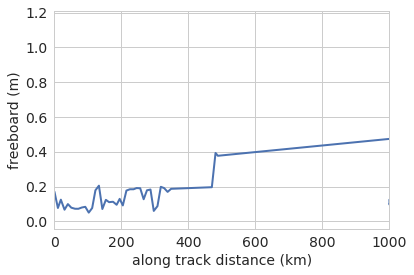

In [73]:
#plot(ATL10file['alongTrackDist'].values, ATL10file['freeboard'].values)
#sns.set_style("darkgrid")
ax=plt.plot(ATL10file['alongTrackDist'].values, ATL10file['freeboard'].values)
#sns.tsplot(ATL10file['alongTrackDist'].values, ATL10file['freeboard'].values)
xlim(0, 1000)
xlabel("along track distance (km)")
ylabel("freeboard (m)")
#ax = plot(x="alongTrackDist", y="freeboard", data=ATL10file)

/home/aapetty/.conda/envs/py36ux/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/aapetty/.conda/envs/py36ux/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


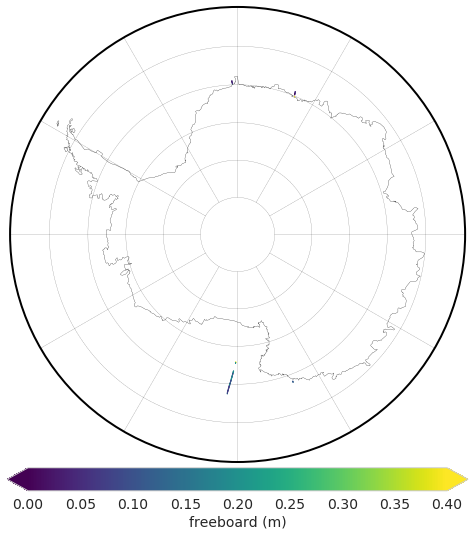

In [75]:
# PLOT data

# plot data on map as a first check
# Change var string to variable of choice (units are meters)
var='freeboard'

rcParams['axes.labelsize'] =14
rcParams['xtick.labelsize']=14
rcParams['ytick.labelsize']=14
rcParams['font.size']=14
rcParams['lines.linewidth'] = 2
rcParams['patch.linewidth'] = 2
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig = figure(figsize=(8,8))
ax=gca()
im1=hexbin(ATL10file['xpts'].values, ATL10file['ypts'].values, vmin=0, vmax=0.4, 
           C=ATL10file[var].values, gridsize=400, cmap=cm.viridis, zorder=2, rasterized=True)
#m.fillcontinents(color='',lake_color='grey', zorder=3)
m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-5), linewidth = 0.25, zorder=10)
m.drawmeridians(np.arange(-180.,180.,30.), latmax=85, linewidth = 0.25, zorder=10)
#x,y = m(-69,-177) # we define the corner 1
#x2,y2 = m(-66,-174) # then corner 2
#ax.set_xlim(x,x2) # and we apply the limits of the zoom plot to the inset axes
#ax.set_ylim(y,y2) # idem

cax = fig.add_axes([0.1, 0.15, 0.8, 0.04])
cbar = colorbar(im1,cax=cax, orientation='horizontal', extend='both',use_gridspec=True)
cbar.set_label(var+' (m)', labelpad=3, fontsize=14)

subplots_adjust(left = 0.01, right = 0.99, bottom=0.2, top = 0.99)
plt.show()
